In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the NHIS 2022 CSV
df = pd.read_csv('nhis_2022.csv')

# Display initial info
initial_shape = df.shape

# Select variables based on user's choice
selected_vars = [
    'DIABETICEV',  # Target
    'AGE', 'SEX', 'BMICALC', 'SAMPWEIGHT', 'EDUC', 'VIG10DMIN', 'PIZZANO', 'POVERTY', 'SODAPNO','HRSLEEP'
]

df_selected = df[selected_vars].copy()

# Recode DIABETICEV: 1 = No/Not mentioned, 2 = Yes
# Convert target into binary: 1 if diagnosed (2), 0 if not (1)
df_selected['DIABETICEV'] = df_selected['DIABETICEV'].replace({1: 0, 2: 1})

# Drop rows with missing or unknown values
def clean_invalid(val):
    if pd.isna(val):
        return None
    if val in [7, 8, 9, 97, 98, 99, 996, 997, 998, 999]:
        return None
    return val

for col in df_selected.columns:
    df_selected[col] = df_selected[col].apply(clean_invalid)

# Now filter the dataset to keep only AGE between 50 and 60 (inclusive)
df_selected = df_selected[(df_selected['AGE'] >= 50) & (df_selected['AGE'] <= 60)]

# Drop any remaining rows with NA
df_clean = df_selected.dropna()

# Recode SEX: 1 = Male -> 0, 2 = Female -> 1
df_clean['SEX'] = df_clean['SEX'].replace({1: 0, 2: 1})

# Separate predictors and target
X = df_clean.drop(columns='DIABETICEV')
y = df_clean['DIABETICEV']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Final cleaned dataset
X_cleaned = pd.DataFrame(X_scaled, columns=X.columns)
y_cleaned = y.reset_index(drop=True)

# Print shape
print(f"Initial shape: {initial_shape}")
print(f"Final shape after cleaning and filtering (AGE 50-60): {df_clean.shape}")


Initial shape: (35115, 48)
Final shape after cleaning and filtering (AGE 50-60): (1513, 11)


<ipython-input-32-0c5f356e0c5b>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['SEX'] = df_clean['SEX'].replace({1: 0, 2: 1})


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Fit a simple logistic regression
logreg = LogisticRegression(max_iter=100)
rfe = RFE(logreg, n_features_to_select=5)
rfe.fit(X_cleaned, y_cleaned)

# Selected features
selected_features_linear = X_cleaned.columns[rfe.support_].tolist()
print("Top variables for Linear SVM :", selected_features_linear)


Top variables for Linear SVM (from RFE): ['BMICALC', 'EDUC', 'VIG10DMIN', 'PIZZANO', 'POVERTY']


In [34]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_cleaned, y_cleaned)

# Rank features by importance
importance = pd.Series(rf.feature_importances_, index=X_cleaned.columns)
importance = importance.sort_values(ascending=False)
selected_features_rbf_poly = importance.head(5).index.tolist()
print("Top variables for Radial and Polynomial SVM (from Random Forest):", selected_features_rbf_poly)


Top variables for Radial and Polynomial SVM (from Random Forest): ['BMICALC', 'SAMPWEIGHT', 'POVERTY', 'AGE', 'EDUC']


In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [7]:
param_grid_linear = {
    'C': [0.01, 0.1, 1]
}

svc_linear = SVC(kernel='linear')
grid_linear = GridSearchCV(svc_linear, param_grid_linear, cv=5, scoring='accuracy')
grid_linear.fit(X_cleaned[selected_features_linear], y_cleaned)

print("Best parameters for Linear SVM:", grid_linear.best_params_)
print("Best CV accuracy for Linear SVM:", grid_linear.best_score_)


Best parameters for Linear SVM: {'C': 0.01}
Best CV accuracy for Linear SVM: 0.8775061124694377


In [8]:
param_grid_rbf = {
    'C': [0.1, 1,0.01],
    'gamma': [0.01, 0.1, 1]
}

svc_rbf = SVC(kernel='rbf')
grid_rbf = GridSearchCV(svc_rbf, param_grid_rbf, cv=5, scoring='accuracy')
grid_rbf.fit(X_cleaned[selected_features_rbf_poly], y_cleaned)

print("Best parameters for RBF SVM:", grid_rbf.best_params_)
print("Best CV accuracy for RBF SVM:", grid_rbf.best_score_)


Best parameters for RBF SVM: {'C': 0.1, 'gamma': 0.01}
Best CV accuracy for RBF SVM: 0.8775061124694377


In [35]:
param_grid_poly = {
    'C': [0.1, 1,0.01],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

svc_poly = SVC(kernel='poly')
grid_poly = GridSearchCV(svc_poly, param_grid_poly, cv=5, scoring='accuracy')
grid_poly.fit(X_cleaned[selected_features_rbf_poly], y_cleaned)

print("Best parameters for Polynomial SVM:", grid_poly.best_params_)
print("Best CV accuracy for Polynomial SVM:", grid_poly.best_score_)


Best parameters for Polynomial SVM: {'C': 0.1, 'degree': 4, 'gamma': 'scale'}
Best CV accuracy for Polynomial SVM: 0.8572421480558653


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler

# # Prepare data: EDUC only
# X_full = df_clean[['EDUC']].copy().reset_index(drop=True)
# y_full = y_cleaned.reset_index(drop=True)

# # Bucket EDUC
# def bucket_educ(val):
#     if 100 <= val < 200:
#         return 1
#     elif 200 <= val < 400:
#         return 2
#     elif 400 <= val <= 505:
#         return 3
#     else:
#         return np.nan

# X_full['EDUC'] = X_full['EDUC'].apply(bucket_educ)

# # Drop invalid
# valid_idx = X_full.dropna().index
# X_subset = X_full.loc[valid_idx].reset_index(drop=True)
# y_subset = y_full.loc[valid_idx].reset_index(drop=True)

# # Standardize
# # scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(X_subset[['EDUC']])
# X_vis = X_subset[['EDUC']]
# y_vis = y_subset

# # Fit model
# model = SVC(kernel='linear', C=grid_linear.best_params_['C'])
# model.fit(X_vis, y_vis)

# # Plot
# xx = np.linspace(X_vis['EDUC'].min() - 1, X_vis['EDUC'].max() + 1, 500).reshape(-1, 1)
# decision_scores = model.decision_function(xx)

# plt.figure(figsize=(10, 6))
# plt.scatter(X_vis['EDUC'], y_vis, c=y_vis, cmap=plt.cm.bwr, s=40, edgecolor='k', alpha=0.7)
# plt.plot(xx, decision_scores, 'k-', label='Decision Function')
# plt.axhline(y=1, color='k', linestyle='--', label='Margin')
# # plt.axhline(y=-1, color='k', linestyle='--')
# plt.axhline(y=0, color='gray', linestyle=':', label='Decision Boundary (0)')

# # Highlight support vectors
# plt.scatter(model.support_vectors_[:, 0], model.decision_function(model.support_vectors_),
#             facecolors='none', edgecolors='k', s=100, label='Support Vectors')

# plt.title("Linear SVM with EDUC Only — Decision Function & Margins", fontsize=14)
# plt.xlabel('EDUC (bucketed & standardized)', fontsize=12)
# plt.ylabel('SVM Decision Function Value', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


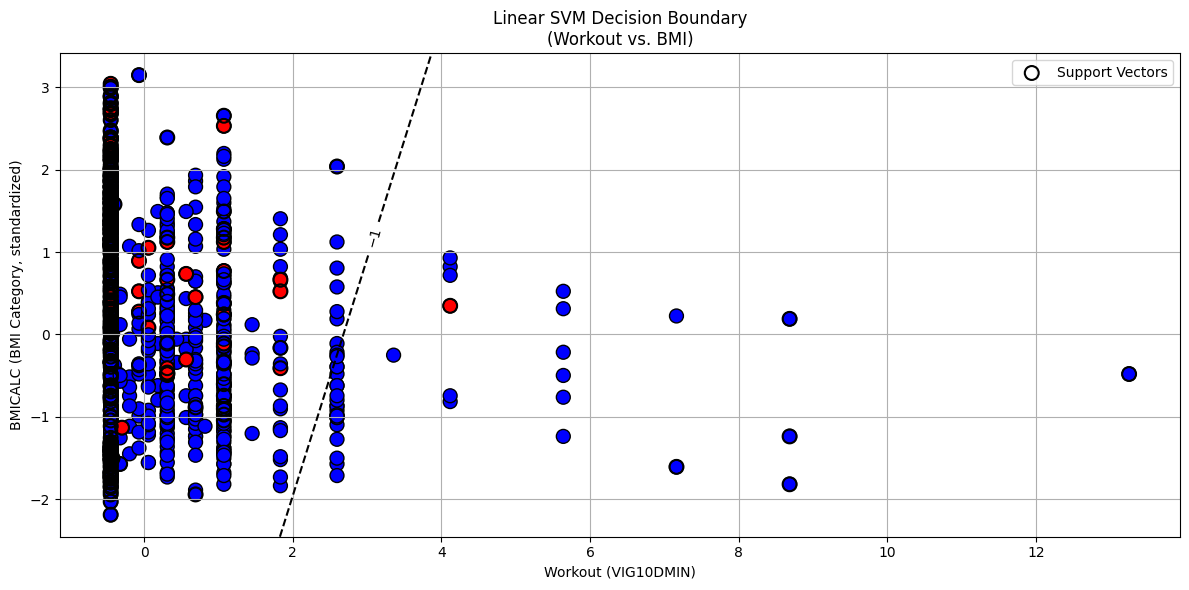

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Select the two features
features = ['VIG10DMIN', 'BMICALC']
X_full = df_clean[features].copy().reset_index(drop=True)
y_full = y_cleaned.reset_index(drop=True)

# Drop missing rows
valid_idx = X_full.dropna().index
X_subset = X_full.loc[valid_idx].reset_index(drop=True)
y_subset = y_full.loc[valid_idx].reset_index(drop=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)
y = y_subset

# Train a Linear SVM
linear_model = SVC(kernel='linear', C=grid_linear.best_params_['C'])
linear_model.fit(X_scaled, y)

# Plot
plt.figure(figsize=(12, 6))

# Color manually (blue and red)
y_int = y.astype(int).to_numpy()
color_map = np.array(['blue', 'red'])

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=color_map[y_int], edgecolors='k', s=100)

# Support vectors
plt.scatter(linear_model.support_vectors_[:, 0], linear_model.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

# Decision function mesh
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 500)
yy = np.linspace(ylim[0], ylim[1], 500)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = linear_model.decision_function(xy).reshape(XX.shape)

# Contours: margins and boundary
contour = plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
                      linestyles=['--', '-', '--'], linewidths=1.5)
plt.clabel(contour, inline=True, fontsize=10)

# Labels and title
plt.xlabel('Workout (VIG10DMIN)')
plt.ylabel('BMICALC (BMI Category, standardized)')
plt.title('Linear SVM Decision Boundary\n(Workout vs. BMI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


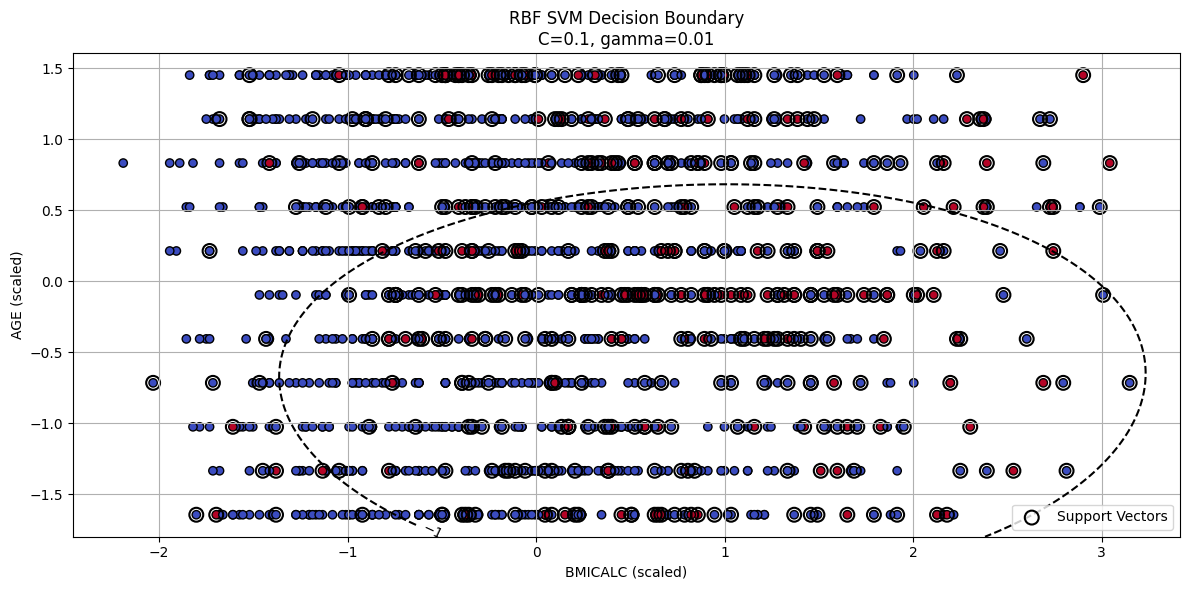

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Select top 2 features for 2D plot
features = ['BMICALC', 'AGE']
X_full = df_clean[features].copy().reset_index(drop=True)
y_full = y_cleaned.reset_index(drop=True)

# Drop rows with missing values
valid_idx = X_full.dropna().index
X_subset = X_full.loc[valid_idx].reset_index(drop=True)
y_subset = y_full.loc[valid_idx].reset_index(drop=True)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)
y = y_subset

# Train RBF SVM
rbf_model = SVC(kernel='rbf', C=grid_rbf.best_params_['C'], gamma=grid_rbf.best_params_['gamma'])
rbf_model.fit(X_scaled, y)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

# Support vectors
plt.scatter(rbf_model.support_vectors_[:, 0], rbf_model.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

# Decision function grid
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 500)
yy = np.linspace(ylim[0], ylim[1], 500)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = rbf_model.decision_function(xy).reshape(XX.shape)

# Plot contours
contour = plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
                      linestyles=['--', '-', '--'], linewidths=1.5)
plt.clabel(contour, inline=True, fontsize=10)

plt.xlabel(f'{features[0]} (scaled)')
plt.ylabel(f'{features[1]} (scaled)')
plt.title(f'RBF SVM Decision Boundary\nC={grid_rbf.best_params_["C"]}, gamma={grid_rbf.best_params_["gamma"]}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


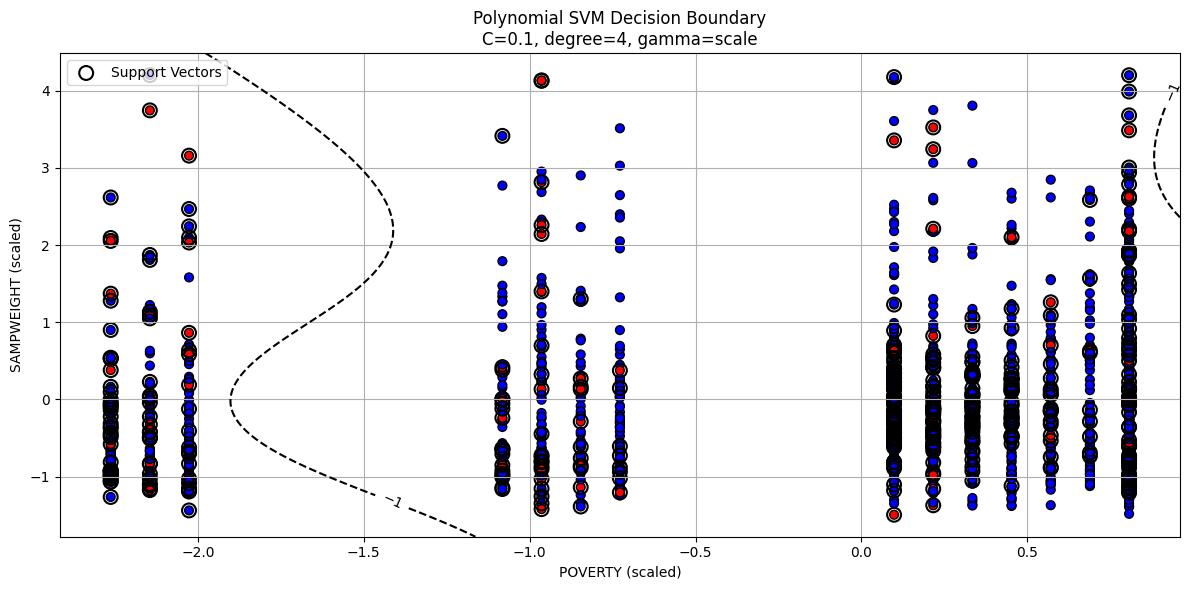

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Select 2 features
features = ['POVERTY', 'SAMPWEIGHT']
X_full = df_clean[features].copy().reset_index(drop=True)
y_full = y_cleaned.reset_index(drop=True)

# Drop missing
valid_idx = X_full.dropna().index
X_subset = X_full.loc[valid_idx].reset_index(drop=True)
y_subset = y_full.loc[valid_idx].reset_index(drop=True)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)
y = y_subset

# Train Polynomial SVM
poly_model = SVC(
    kernel='poly',
    C=grid_poly.best_params_['C'],
    degree=grid_poly.best_params_['degree'],
    gamma=grid_poly.best_params_['gamma']
)
poly_model.fit(X_scaled, y)

# Plot
plt.figure(figsize=(12, 6))

# First: map y to integers
y_int = y.astype(int).to_numpy()

# Then: manually define colors
color_map = np.array(['blue', 'red'])  # 0 -> blue, 1 -> red

# Now plot safely
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=color_map[y_int], edgecolors='k', s=40)

# Support vectors
plt.scatter(poly_model.support_vectors_[:, 0], poly_model.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

# Decision function grid
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 500)
yy = np.linspace(ylim[0], ylim[1], 500)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = poly_model.decision_function(xy).reshape(XX.shape)

# Plot contours
contour = plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
                      linestyles=['--', '-', '--'], linewidths=1.5)
plt.clabel(contour, inline=True, fontsize=10)

plt.xlabel(f'{features[0]} (scaled)')
plt.ylabel(f'{features[1]} (scaled)')
plt.title(f'Polynomial SVM Decision Boundary\nC={grid_poly.best_params_["C"]}, '
          f'degree={grid_poly.best_params_["degree"]}, gamma={grid_poly.best_params_["gamma"]}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Train the best models again using the best parameters from GridSearchCV

# 1. Linear SVM
svc_linear = SVC(kernel='linear', C=grid_linear.best_params_['C'])
svc_linear.fit(X_cleaned[selected_features_linear], y_cleaned)
y_pred_linear = svc_linear.predict(X_cleaned[selected_features_linear])

# 2. RBF SVM
svc_rbf = SVC(kernel='rbf', C=grid_rbf.best_params_['C'], gamma=grid_rbf.best_params_['gamma'])
svc_rbf.fit(X_cleaned[selected_features_rbf_poly], y_cleaned)
y_pred_rbf = svc_rbf.predict(X_cleaned[selected_features_rbf_poly])

# 3. Polynomial SVM
svc_poly = SVC(kernel='poly',
               C=grid_poly.best_params_['C'],
               degree=grid_poly.best_params_['degree'],
               gamma=grid_poly.best_params_['gamma'])
svc_poly.fit(X_cleaned[selected_features_rbf_poly], y_cleaned)
y_pred_poly = svc_poly.predict(X_cleaned[selected_features_rbf_poly])

# Helper function to print evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n--- {model_name} SVM Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))

# Evaluate all models
evaluate_model(y_cleaned, y_pred_linear, "Linear")
evaluate_model(y_cleaned, y_pred_rbf, "RBF")
evaluate_model(y_cleaned, y_pred_poly, "Polynomial")



--- Linear SVM Evaluation ---
Accuracy: 0.8559
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Confusion Matrix:
 [[1295    0]
 [ 218    0]]
              precision    recall  f1-score   support

         0.0     0.8559    1.0000    0.9224      1295
         1.0     0.0000    0.0000    0.0000       218

    accuracy                         0.8559      1513
   macro avg     0.4280    0.5000    0.4612      1513
weighted avg     0.7326    0.8559    0.7895      1513


--- RBF SVM Evaluation ---
Accuracy: 0.8559
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Confusion Matrix:
 [[1295    0]
 [ 218    0]]
              precision    recall  f1-score   support

         0.0     0.8559    1.0000    0.9224      1295
         1.0     0.0000    0.0000    0.0000       218

    accuracy                         0.8559      1513
   macro avg     0.4280    0.5000    0.4612      1513
weighted avg     0.7326    0.8559    0.7895      1513


--- Polynomial SVM Evaluation ---
Accuracy: 0.8579
Precision

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_